In [1]:
import matplotlib.pyplot as plt
from networkx import nx
import numpy as np
from itertools import count
import random
import math
import copy 
import time

In [2]:
# pre-set notation
sub_game_number = 6
att_strategy_number = 8
def_strategy_number = 8

N = 100  # number of nodes
P = 0.05  # connection probability
SF_thres = 0.3  # A threshold for SF
low_inter = 10  # number of low interaction honeypots
high_inter = 5  # number of high interaction honeypots
inter_per_node = 3 # one honeypot connect to 3 nodes
N_ws = 5  # number of Web servers
N_db = 5  # number of databases
N_iot = N - N_ws - N_db  # number of IoT nodes
ev = 5  # encryption vulnerability
sv = 5  # software vulnerability
uv = 1  # unknown vulnerability
ev_lambda = 1 # λ for normalize encryption vulnerability
rewire_probability = 0.1 # rewire probability
saved_file_name_index = "1" # for draw_graph function
P_fake = 0 # fake key for DS7
att_detect = [0.2] * def_strategy_number # attacker detectability for defender's strategies
def_monit_time = 0 # defneder monitoring time
att_in_system_time = 1 # attacker in system time
system_lifetime = 0  # system lifetime start from 0
T_rekey = 0 # rekey time for encryption vulnerability
dec = 0 # defense deception

In [3]:
# graph
H_G = None
G_real = None

In [4]:
# create honeypot graph
def new_honeypot():
    global H_G, low_inter,high_inter
    H_G = nx.complete_graph(low_inter + high_inter)  # new graph for honeypot
    mapping = {}
    for n in range(low_inter):
        mapping[n] = "LI" + str(n)
    #     nx.relabel_nodes(H_G, {n:"LI"+str(n)})
    for n in range(high_inter):
        mapping[n + low_inter] = "HI" + str(n)
    #     nx.relabel_nodes(H_G, {n+low_inter:"HI"+str(n)})
    H_G = nx.relabel_nodes(H_G, mapping)
    print("honeypot graph")
    H_G = H_G.to_directed()
    
    plt.figure()
    nx.draw(H_G, with_labels=True)

In [5]:
# create real node graph
def new_real_graph():
    global G_real, N, P
    G_real = nx.erdos_renyi_graph(N, P)  # undirected graph
    while not nx.is_connected(G_real):
        print("rebuild")
        G_real = nx.erdos_renyi_graph(N, P)  # rebuild undirected graph

    print("real graph")
    plt.figure()
    nx.draw(G_real, with_labels=True)

In [6]:
# update vulnerability_i value
# Call this function to update vulnerability_i calculation
def update_vul(G):
    nx.set_node_attributes(G, 0, "vulnerability")
    nx.set_node_attributes(G, 0, "normalized_vulnerability")
    for n in G.nodes():
        G.nodes[n]["vulnerability"] = (
            sum(G.nodes[n]["software vulnerability"]) +
            sum(G.nodes[n]["encryption vulnerability"]) +
            sum(G.nodes[n]["unknown vulnerability"])) / (
                len(G.nodes[n]["software vulnerability"]) +
                len(G.nodes[n]["encryption vulnerability"]) +
                len(G.nodes[n]["unknown vulnerability"]))
        G.nodes[n]["normalized_vulnerability"] = G.nodes[n]["vulnerability"]/10
    return G

In [7]:
# set node type
# 0 means IoT devices, 1 means Web Server, 2 means Dataset, 3 means Honeypot
def set_type(G):
    if "type" not in G.nodes[0]:
        nx.set_node_attributes(G, 0, "type")
    for n in range(N_ws):
        G.nodes[n]["type"] = 1
    for n in range(N_db, N_ws + N_db):
        G.nodes[n]["type"] = 2
    return G


def set_type_for_HP(H_G):
    if "type" not in H_G.nodes['LI0']:
        nx.set_node_attributes(H_G, 0, "type")
    for n in ["LI" + str(n) for n in range(low_inter)]:
        H_G.nodes[n]["type"] = 3
    for n in ["HI" + str(n) for n in range(high_inter)]:
        H_G.nodes[n]["type"] = 3
    return H_G

In [8]:
# set honeypot attribute
# 0 means not a honeypot, 1 means low interaction honeypot, 2 means high interaction honeypot
def set_HP_attribute(G):
    nx.set_node_attributes(G, 0, "honeypot")
    for n in G.nodes():
        if G.nodes[n]["type"] == 3:
            if n[0] == 'L':
                G.nodes[n]["honeypot"] = 1
            else:
                G.nodes[n]["honeypot"] = 2

    return G


#     if "honeypot" not in G.nodes[0]:
#         nx.set_node_attributes(G, 0, "honeypot")
#     return G

# def set_HP_attribute_for_HP(H_G):
#     if "honeypot" not in H_G.nodes['LI0']:
#         nx.set_node_attributes(H_G, 0, "honeypot")
#     # add low/high interaction
#     for n in ["LI"+str(n) for n in range(low_inter)]:
#         H_G.nodes[n]["honeypot"] = 1
#     for n in ["HI"+str(n) for n in range(high_inter)]:
#         H_G.nodes[n]["honeypot"] = 2
#     return H_G

In [9]:
# update time-based encryption vulnerability
def update_en_vul(G):
    global T_rekey
    T_rekey += 1
    for n in G.nodes():
        for index in range(ev):
            G.nodes[n]["encryption vulnerability"][index] = G.nodes[n][
                "original_encryption_vulnerability"][index] * math.exp(
                    -ev_lambda / T_rekey)

    return G

In [10]:
# APV: value of an intermediate node i in an attack path
def calc_APV(G, node_ID, attack_cost):
    if G.nodes[node_ID]["compromised_status"]:
        return 1
    else:
        return (1 - (attack_cost/3) ) * G.nodes[node_ID]["normalized_vulnerability"]

In [11]:
def set_security_vulnerability(G):
    # set security vulnerability
    nx.set_node_attributes(G, [0] * sv, "software vulnerability")
    nx.set_node_attributes(G, [0] * ev, "original_encryption_vulnerability")
    nx.set_node_attributes(G, [0] * ev, "encryption vulnerability")
    nx.set_node_attributes(G, [0] * uv, "unknown vulnerability")

    # add three types vulnerability value based on essay TABLE 1
    for n in G.nodes():
        if G.nodes[n]["type"] == 0:
            G.nodes[n]["software vulnerability"] = [
                random.randint(1, 5) for iter in range(sv)
            ]
            G.nodes[n]["original_encryption_vulnerability"] = [
                random.randint(5, 10) for iter in range(ev)
            ]
            G.nodes[n]["unknown vulnerability"] = [
                random.randint(0, 10) for iter in range(uv)
            ]
        elif G.nodes[n]["type"] == 1:
            G.nodes[n]["software vulnerability"] = [
                random.randint(3, 7) for iter in range(sv)
            ]
            G.nodes[n]["original_encryption_vulnerability"] = [
                random.randint(1, 3) for iter in range(ev)
            ]
            G.nodes[n]["unknown vulnerability"] = [
                random.randint(0, 10) for iter in range(uv)
            ]
        elif G.nodes[n]["type"] == 2:
            G.nodes[n]["software vulnerability"] = [
                random.randint(3, 7) for iter in range(sv)
            ]
            G.nodes[n]["original_encryption_vulnerability"] = [
                random.randint(1, 3) for iter in range(ev)
            ]
            G.nodes[n]["unknown vulnerability"] = [
                random.randint(0, 10) for iter in range(uv)
            ]
        else:
            G.nodes[n]["software vulnerability"] = [
                random.randint(7, 10) for iter in range(sv)
            ]
            G.nodes[n]["original_encryption_vulnerability"] = [
                random.randint(9, 10) for iter in range(ev)
            ]
            G.nodes[n]["unknown vulnerability"] = [
                random.randint(0, 10) for iter in range(uv)
            ]

    # update encryption vulnerability
    G = update_en_vul(G)
    # update overall vulnerability
    G = update_vul(G)
    return G

In [12]:
# set importance
def set_importance(G):
    nx.set_node_attributes(G, 0, "importance")
    for n in G.nodes():
        if G.nodes[n]["type"] == 0:
            G.nodes[n]["importance"] = random.randint(1, 5)
        elif G.nodes[n]["type"] == 1:
            G.nodes[n]["importance"] = random.randint(8, 10)
        elif G.nodes[n]["type"] == 2:
            G.nodes[n]["importance"] = random.randint(8, 10)
    return G

In [13]:
# draw with color
def draw_graph(G):
    global saved_file_name_index
    
    plt.figure()
    groups = set(nx.get_node_attributes(G, 'honeypot').values())
    mapping = dict(zip(sorted(groups), count()))
    colors = [mapping[G.nodes[n]['honeypot']] for n in G.nodes()]

#     rounded_vul = dict((k, G.nodes[k]["compromised_status"]) for k in G.nodes())
    options = {
        "pos": nx.circular_layout(G),
        "node_color": colors,
        "node_size": 20,
        "arrowsize": 3,
        "line_color": "grey",
        "linewidths": 0,
        "width": 0.1,
        "with_labels": True,
        "font_size": 3,
        "font_color": 'w',
#         "labels": rounded_vul,
    }
    nx.draw(G,  **options)
    
    plt.savefig("graph"+saved_file_name_index+".png", dpi=1000)

In [14]:
# reachability (sum of betweenness_centrality value is not one(1))
def set_reachability(G):
    nx.set_node_attributes(G, 0, "reachability")
    reachability = nx.betweenness_centrality(G)
    for n in G.nodes():
        G.nodes[n]["reachability"] = reachability[n]
    return G

In [15]:
# Criticality
def updata_criticality(G):
    
    G = set_reachability(G)
    
    nx.set_node_attributes(G, 0, "criticality")
    for n in G.nodes():
        G.nodes[n]["criticality"] = G.nodes[n]["importance"] * G.nodes[n][
            "reachability"]
    return G

In [16]:
# Mobility
def set_mobility(G):
    nx.set_node_attributes(G, 0, "mobility")
    for n in G.nodes():
        if G.nodes[n]["type"] == 0: # only for IoT devices
            G.nodes[n]["mobility"] = 0.1 #random.uniform(0,0.5)
    return G
            

In [17]:
# Compromised Status
# For devices: False means not compromised, True means compromised.
# For honeypots: False means not visited by attacker, True means visited by attacker

def set_compromised_status(G):
    nx.set_node_attributes(G, False, "compromised_status")
    return G

In [18]:
# Attack Impact by given attack k
# new_compromised_list is new compromised ndoe IDs (do not include already compromised node)
def attack_impact(G, new_compromised_list):
    
    if new_compromised_list == None:
        return 0
    
    total_criticality = 0
    for n in new_compromised_list:
        total_criticality += G.nodes[n]["criticality"]
    ai = total_criticality/N
    return ai

In [19]:
# Check System Failure

def is_system_fail():
    top_total = 0;
    bottom_total = 0;
    for n in G_real.nodes():
        top_total += G_real.nodes[n]["compromised_status"] * G_real.nodes[n]["criticality"]
        bottom_total += G_real.nodes[n]["criticality"]
    if top_total/bottom_total >= SF_thres:
        print("System Fail \U0001F480")
        return True
    else:
        print("System not Fail \U0001F44D")
        return False

In [20]:
# set ID in attribute
def set_id(G):
    nx.set_node_attributes(G, 0, "id")
    for n in G.nodes():
        G.nodes[n]["id"] = n
    return G

In [21]:
# AS1 – Monitoring attack
# (keep try untile get one)
# return: a dictionary contain all information
def attack_AS_1():
    global G_real, G_att, G_def  # load global variable
    
    
    not_get_one = True
    while not_get_one:
        random_id = random.randint(0, N - 1)
        if random.random() <= G_real.nodes[random_id]["normalized_vulnerability"]: # success rate is based on real graph
            node_info = G_att.nodes[random_id]
            not_get_one = False
    node_info["attack_cost"] = 1
    return node_info


In [22]:
# AS2 – Social engineering
# input: node_info_list: nodes with information collected (dictionary type)
#         attacker_location: attacker location for inside attacker. 
#                           If it is None or not given, this means it's outside attacker
# return: a dictionary with "attack cost", and compromised "ids". "ids" is empty if unsuccessful

def attack_AS_2(node_info_list, attacker_location=None):
    global G_real, G_att, G_def, P_fake
    
    attack_cost = 3
    
    attack_result = {"attack_cost": attack_cost, "ids": []}
    
    if random.random() <= P_fake:
        print("get fake key, failed to compromise")
        return attack_result
    
    max_APV_id = None
    max_APV = 0
    if attacker_location == None:
        # outside attacker
        for node_n in node_info_list:
            if not node_n["compromised_status"]:  # for uncompromising nodes
                if calc_APV(G_att, node_n["id"], attack_cost) >= max_APV: # choose node with APV
                    max_APV = calc_APV(G_att, node_n["id"], attack_cost)
                    max_APV_id = node_n["id"]
    else:
        # inside attacker
        for n in G_att.neighbors(attacker_location):
            if not G_real.nodes[n]["compromised_status"]:  # for uncompromising nodes
                print(calc_APV(G_att, n, attack_cost))
                if calc_APV(G_att, n, attack_cost) >= max_APV:
                    max_APV = calc_APV(G_att, n, attack_cost)
                    max_APV_id = n
    
    
    if max_APV_id == None:
        print("no legitimate neighbor node \U0001F630")
        return attack_result
    
    if random.random() < G_real.nodes[max_APV_id]["normalized_vulnerability"]:
        attack_result["ids"].append(max_APV_id)
        G_real.nodes[max_APV_id]["compromised_status"] = True  # set it compromised
        G_att.nodes[max_APV_id]["compromised_status"] = True
        G_def.nodes[max_APV_id]["compromised_status"] = True
    else:
        print("AS2: unsuccessful on", max_APV_id, "with vul",
              G_real.nodes[max_APV_id]["normalized_vulnerability"])
    
    attack_result["ids"] = NIDS_detect(attack_result["ids"])
    
    return attack_result

In [23]:
# AS3 – Botnet-based attack
# (a legitimate node with more than one compromised node will be tried more than one times)
# return: attack_result["ids"] is new compromised ids

def attack_AS_3():
    global G_real, G_att, G_def, P_fake
    
    attack_result = {"attack_cost": 3, "ids": []}
    
    if random.random() <= P_fake:
        print("get fake key, failed to compromise")
        return attack_result
    
    compromised_nodes = []
    for n in G_att.nodes():
        if G_real.nodes[n]["compromised_status"]:
            compromised_nodes.append(n)
    attacked_adjacent = []
    for n in compromised_nodes:
        attacked_adjacent.extend(G_att.neighbors(n))

    attacked_adjacent = list(set(attacked_adjacent))
    
    for n in attacked_adjacent:
        if not G_real.nodes[n]["compromised_status"]:
            if random.random() <= G_real.nodes[n]["normalized_vulnerability"]:
                G_real.nodes[n]["compromised_status"] = True
                G_att.nodes[n]["compromised_status"] = True
                G_def.nodes[n]["compromised_status"] = True
                attack_result["ids"].append(n)
    
    if not attack_result["ids"]:
        print("attack 3 failed")

    attack_result["ids"] = NIDS_detect(attack_result["ids"])
    
    return attack_result


In [24]:
# AS4 – Distributed Denial-of-Service (DDoS)
# return: attack_result["ids"] is the node that Unknow Vulnerability(UV) increased


def attack_AS_4():
    global G_real, G_att, G_def
    
    compromised_nodes = []
    for n in G_att.nodes():
        if G_real.nodes[n]["compromised_status"]:
            compromised_nodes.append(n)
    attacked_adjacent = []
    for n in compromised_nodes:
        attacked_adjacent.extend(G_att.neighbors(n))

    attack_result = {"attack_cost": 3, "ids": []}
    for n in attacked_adjacent:
        if not G_real.nodes[n]["compromised_status"]:
            G_real.nodes[n]["unknown vulnerability"][0] = min(
                G_real.nodes[n]["unknown vulnerability"][0] * 1.1, 10)

            G_att.nodes[n]["unknown vulnerability"][0] = min(
                G_att.nodes[n]["unknown vulnerability"][0] * 1.1, 10)

            G_def.nodes[n]["unknown vulnerability"][0] = min(
                G_def.nodes[n]["unknown vulnerability"][0] * 1.1, 10)

            attack_result["ids"].append(n)
            
    if not attack_result["ids"]:
        print("attack 4 failed")
        
    # update vulnerability
    G_real = update_vul(G_real)
    G_att = update_vul(G_att)
    G_def = update_vul(G_def)
    
    
    return attack_result

In [25]:
# AS5 – Zero-day attacks
# (pick the adjacent node with max 'uv')
def attack_AS_5():
    global G_real, G_att, G_def
    
    attack_cost = 1
    
    compromised_nodes = []
    for n in G_att.nodes():
        if G_real.nodes[n]["compromised_status"]:
            compromised_nodes.append(n)
    attacked_adjacent = []
    for n in compromised_nodes:
        attacked_adjacent.extend(G_att.neighbors(n))
        
    attack_result = {"attack_cost": attack_cost, "ids": []}

    if not len(attacked_adjacent):
        print("no legitimate neighbor node \U0001F630")
        return attack_result

    max_APV_id = None
    max_APV = 0
    #     get node_id with max 'uv'
    for n in attacked_adjacent:
        if not G_real.nodes[n]["compromised_status"]:
            if calc_APV(G_att, n, attack_cost) >= max_APV:
                max_APV_id = n
                max_APV = calc_APV(G_att, n, attack_cost)

    
    #     try compromising
    if random.randint(0, 10) <= G_real.nodes[max_APV_id]["unknown vulnerability"][0]:
        G_real.nodes[max_APV_id]["compromised_status"] = True
        G_att.nodes[max_APV_id]["compromised_status"] = True
        G_def.nodes[max_APV_id]["compromised_status"] = True
        attack_result["ids"].append(max_APV_id)
    
    if not attack_result["ids"]:
        print("attack 5 failed")

    attack_result["ids"] = NIDS_detect(attack_result["ids"])
    
    return attack_result

In [26]:
# AS6 – Breaking encryption
# (TODO: do adjacent)


def attack_AS_6():
    global G_real, G_att, G_def, P_fake
    
    attack_cost = 3
    attack_result = {"attack_cost": attack_cost, "ids": []}
    
    if random.random() <= P_fake:
        print("get fake key, failed to compromise")
        return attack_result

    compromised_nodes = []
    for n in G_att.nodes():
        if G_real.nodes[n]["compromised_status"]:
            compromised_nodes.append(n)
    attacked_adjacent = []
    for n in compromised_nodes:
        attacked_adjacent.extend(G_att.neighbors(n))

    

    if not len(attacked_adjacent):
        print("no legitimate neighbor node \U0001F630")
        return attack_result

    max_APV_id = None
    max_APV = 0
    #     get node_id with max 'nv'
    for n in attacked_adjacent:
        if not G_real.nodes[n]["compromised_status"]:
            if calc_APV(G_att, n, attack_cost)>= max_APV:
                max_APV_id = n
                max_APV = calc_APV(G_att, n, attack_cost)

    if random.random() <= G_real.nodes[max_APV_id]["normalized_vulnerability"]:
        G_real.nodes[max_APV_id]["compromised_status"] = True
        G_att.nodes[max_APV_id]["compromised_status"] = True
        G_def.nodes[max_APV_id]["compromised_status"] = True
        attack_result["ids"].append(max_APV_id)
    else:
        print("AS6: unsuccessful on", max_APV_id, "with APV",
              max_APV)

    if not attack_result["ids"]:
        print("attack 6 failed")
    
    attack_result["ids"] = NIDS_detect(attack_result["ids"])
    
    return attack_result

In [27]:
# AS7 – Fake identity
def attack_AS_7():
    global G_real, G_att, G_def, P_fake
    
    attack_cost = 2
    attack_result = {"attack_cost": attack_cost, "ids": []}
    
    if random.random() <= P_fake:
        print("get fake key, failed to compromise")
        return attack_result
    
    compromised_nodes = []
    for n in G_att.nodes():
        if G_real.nodes[n]["compromised_status"]:
            compromised_nodes.append(n)
    attacked_adjacent = []
    for n in compromised_nodes:
        attacked_adjacent.extend(G_att.neighbors(n))

    

    if not len(attacked_adjacent):
        print("no legitimate neighbor node \U0001F630")
        return attack_result

    max_APV_id = None
    max_APV = 0
    #     get node_id with max 'uv'
    for n in attacked_adjacent:
        if not G_real.nodes[n]["compromised_status"]:
            if calc_APV(G_att, n, attack_cost) >= max_APV:
                max_APV_id = n
                max_APV = calc_APV(G_att, n, attack_cost)
            
    #     try compromising
    for index in range(len(G_att.nodes[n]["encryption vulnerability"])):
        if random.randint(0, 10) <= G_real.nodes[max_APV_id]["encryption vulnerability"][index]:
            G_real.nodes[max_APV_id]["compromised_status"] = True
            G_att.nodes[max_APV_id]["compromised_status"] = True
            G_def.nodes[max_APV_id]["compromised_status"] = True
            attack_result["ids"].append(max_APV_id)
            break
    
    if not attack_result["ids"]:
        print("attack 7 failed")
        
    attack_result["ids"] = NIDS_detect(attack_result["ids"])
    
    return attack_result

In [28]:
# AS8 – Data exfiltration
def attack_AS_8():
    global G_real, G_att, G_def
    
    Thres_c = 0.6  # pre-set value
    
    total_compromised_criticality = 0
    for n in G_real.nodes():
        if G_real.nodes[n]["compromised_status"]:
            total_compromised_criticality += G_real.nodes[n]["criticality"]
    
    if total_compromised_criticality>Thres_c:
        print("Data exfiltration success")
        print("total collected criticality is", total_compromised_criticality)
        return True
    else:
        print("Data exfiltration failed")
        return False

In [29]:
def evict_a_node(remove_id):
    global G_real, G_def, G_att
    
    node_neighbor = list(G_def.neighbors(remove_id))
    
    for neighbor_index in node_neighbor:
        if G_real.has_edge(n,neighbor_index): G_real.remove_edge(remove_id,neighbor_index) 
        if G_def.has_edge(n,neighbor_index): G_def.remove_edge(remove_id,neighbor_index)
        if G_att.has_edge(n,neighbor_index): G_att.remove_edge(remove_id,neighbor_index)
        
    # update criticality
    G_real = updata_criticality(G_real)
    G_def = updata_criticality(G_def)
    G_att = updata_criticality(G_att)

In [30]:
# NIDS eviction
# TODO: Consider False Positive
def NIDS_detect(detected_ids):
    global G_real
    
#     false negative rate
    false_neg = 0.1
    
    false_pos = 0.1
    
    Th_risk = 0.2  # pre-set value
    
    reserved_node = []
    for id_index in detected_ids:
        if random.random() < false_neg:
            print("false negative on node: "+str(id_index))
            reserved_node.append(id_index)
        else:
            if G_real.nodes[id_index]["criticality"] < Th_risk:
                
                # check system fail
                top_total = 0;
                bottom_total = 0;
                for n in G_real.nodes():
                    top_total += G_real.nodes[n]["compromised_status"] * G_real.nodes[n]["criticality"]
                    bottom_total += G_real.nodes[n]["criticality"]
                if top_total/bottom_total >= SF_thres:
                    print("node will cause system fail, evict it: "+str(id_index))
                    evict_a_node(id_index)
                else:
                    print("keep compromised node: "+str(id_index))
                    reserved_node.append(id_index)
            else:
                print("evict compromised node: "+str(id_index))
                evict_a_node(id_index)
                
            
    return reserved_node

In [31]:
# DS1 – Firewalls
# REVIEW
def defense_DS_1():
    global G_real, G_att, G_def
    
    for n in G_real.nodes():
        G_real.nodes[n]["unknown vulnerability"][0] = max(G_real.nodes[n]["unknown vulnerability"][0]-1, 0)
    
    for n in G_att.nodes():
        G_att.nodes[n]["unknown vulnerability"][0] = max(G_att.nodes[n]["unknown vulnerability"][0]-1, 0)
        
    for n in G_def.nodes():
        G_def.nodes[n]["unknown vulnerability"][0] = max(G_def.nodes[n]["unknown vulnerability"][0]-1, 0)


In [32]:
# DS2 – Patch Management
# REVIEW
def defense_DS_2():
    global G_real, G_att, G_def
    
    for index in range(sv):
        for n in G_real.nodes():
            G_real.nodes[n]["software vulnerability"][index] = max(G_real.nodes[n]["software vulnerability"][index]-1, 0)

        for n in G_real.nodes():
            G_att.nodes[n]["software vulnerability"][index] = max(G_att.nodes[n]["software vulnerability"][index]-1, 0)

        for n in G_real.nodes():
            G_def.nodes[n]["software vulnerability"][index] = max(G_def.nodes[n]["software vulnerability"][index]-1, 0)


In [33]:
# DS3 – Rekeying Cryptographic Keys
def defense_DS_3():
    global T_rekey, G_real, G_att, G_def
    
    T_rekey = 0
    
    G_real = update_en_vul(G_real)
    G_att = update_en_vul(G_att)
    G_def = update_en_vul(G_def)
    
    G_real = update_vul(G_real)
    G_att = update_vul(G_att)
    G_def = update_vul(G_def)

In [34]:
# DS4 – Eviction
# return actural removed node
# TODO: REVIEW
def defense_DS_4():
    global G_real, G_att, G_def
    
    Detection_rate = 0.9
    saved_nodes = [];

    for n in list(G_def.nodes()): # list() avoid "dictionary changed size during iteration Error"
        if G_def.nodes[n]["compromised_status"]: # defender belived compromised node
            
            print("|| did")
            node_neighbor = list(G_def.neighbors(n))
            for neighbor_index in node_neighbor:
                if G_def.has_edge(n,neighbor_index): G_def.remove_edge(n,neighbor_index)
                
            if random.random() < Detection_rate:
                print("= did")
                for neighbor_index in node_neighbor:
                    if G_real.has_edge(n,neighbor_index): G_real.remove_edge(n,neighbor_index)
                    if G_att.has_edge(n,neighbor_index): G_att.remove_edge(n,neighbor_index)
                saved_nodes.append(n)
#             G_def.remove_node(n)  # defender think all compromised node are evicted
#             if random.random() < Detection_rate:
#                 G_real.remove_node(n)
#                 G_att.remove_node(n)
#                 saved_nodes.append(n)
                
    return {"ids": saved_nodes}

In [35]:
# DS5 – Low/High-Interaction Honeypots
def defense_DS_5():
    global G_real, G_att, G_def, H_G, high_inter, low_inter, inter_per_node

    legitimate_nodes = {}
    for n in G_def.nodes():  # in defender view
        if not G_def.nodes[n]["compromised_status"]:
            legitimate_nodes[n] = G_def.nodes[n]["normalized_vulnerability"]
    sorted_node_index = sorted(legitimate_nodes,
                               key=legitimate_nodes.__getitem__,
                               reverse=True)  # sort from high to low

    # undirected to directed
    G_real = G_real.to_directed()
    G_att = G_att.to_directed()
    G_def = G_def.to_directed()

    # add honeypot network to main network
    G_real = nx.compose(G_real, H_G)
    G_att = nx.compose(G_att, H_G)
    G_def = nx.compose(G_def, H_G)

    # HI to top 15
    counter = 0
    for n in range(high_inter):
        for i in range(inter_per_node):  # 3 per HI honeypot
            G_real.add_edge(sorted_node_index[counter], "HI" + str(n))
            G_att.add_edge(sorted_node_index[counter], "HI" + str(n))
            G_def.add_edge(sorted_node_index[counter], "HI" + str(n))
            counter += 1
    # LI to next top 30
    for n in range(low_inter):
        for i in range(inter_per_node):  # 3 per LI honeypot
            G_real.add_edge(sorted_node_index[counter], "LI" + str(n))
            G_att.add_edge(sorted_node_index[counter], "LI" + str(n))
            G_def.add_edge(sorted_node_index[counter], "LI" + str(n))
            counter += 1
    return {
        "HI_ids": sorted_node_index[:(high_inter * inter_per_node - 1)],
        "LI_ids": sorted_node_index[(high_inter * inter_per_node):]
    }
# Update network attribute

In [36]:
# DS6 – Honey information
# this defend randomly decrease vulnerability in attacker view
# attack detect probability ?

def defense_DS_6():
    global G_att, sv, ev

    for n in G_att.nodes():
        # change software vulnerability
        for sv_index in range(sv):
            G_att.nodes[n]["software vulnerability"][
                sv_index] += random.randint(
                    -G_att.nodes[n]["software vulnerability"][sv_index],
                    10 - G_att.nodes[n]["software vulnerability"][sv_index])
        
        # change encryption vulnerability
        for ev_index in range(ev):
            G_att.nodes[n]["original_encryption_vulnerability"][
                ev_index] += random.randint(-G_att.nodes[n]["original_encryption_vulnerability"][ev_index], 10 - G_att.nodes[n]["original_encryption_vulnerability"][ev_index])
        
        # change unknown vulnerability
        G_att.nodes[n]["unknown vulnerability"][
            0] += random.randint(
                -G_att.nodes[n]["unknown vulnerability"][0],
                10 - G_att.nodes[n]["unknown vulnerability"][0])
    
    G_att = update_en_vul(G_att)
    G_att = update_vul(G_att)
    

In [37]:
# DS7 – Fake keys
# （this defense only affect AS_6, since it's the only attack relate to key
# update for AS using encryption vul.
def defense_DS_7():
    global P_fake, att_detect
    
    P_fake = 0.5 - att_detect[6]

In [38]:
# DS8 – Hiding network topology edges
# randomly pick a node, and remove the edge connect to highest criticality node among the node nieghbor
def defense_DS_8():
    global G_real, G_att, G_def
    
    edge_number = G_att.number_of_edges()
    to_remove_edge_number = int(round(edge_number*0.2))
    print("remove "+str(to_remove_edge_number)+" edges")
    
    node_id_set = G_att.nodes()
    while to_remove_edge_number!=0:
        chosen_node = random.choice(node_id_set)
#         print(chosen_node["id"])
#         to_remove_edge_number-=1
        
        # get max adjacent node
        max_criticality_id = None
        max_criticality_value = 0
        for neighbor_id in G_att.neighbors(chosen_node["id"]):
            if G_att.nodes[neighbor_id]["criticality"] > max_criticality_value:
                max_criticality_id = neighbor_id
                max_criticality_value = G_att.nodes[neighbor_id]["criticality"]

        # remove edge
        if max_criticality_id != None:
            G_att.remove_edge(chosen_node["id"], max_criticality_id)
            to_remove_edge_number-=1
            print("remove edge ["+str(chosen_node["id"])+" , "+str(max_criticality_id)+"]")
        
        
        

In [39]:
# defense_DS_8()

In [40]:
# if monitored_info["id"] != None:
#     APV = calc_APV(G, monitored_info["id"], monitored_info["attack_cost"])
#     print(APV)

# operate attack AS_1
# monitored_info = attack_AS_1()
# attacker_collection_list.append(monitored_info)
# print(attacker_collection_list)


# operate attack AS_2
# attack_result_2 = attack_AS_2(attacker_collection_list)
# print(attack_result_2)


# operate attack AS_3
# attack_result_3 = attack_AS_3()
# print(attack_result_3)

# operate attack AS_4
# attack_result_4 = attack_AS_4()
# print(attack_result_4)

# operate attack AS_5
# attack_result_5 = attack_AS_5()
# print(attack_result_5);

# operate attack AS_6
# attack_result_6 = attack_AS_6()
# print(attack_result_6);

# operate attack AS_7
# attack_result_7 = attack_AS_7()
# print(attack_result_7);

# # operate attack AS_8
# attack_result_8 = attack_AS_8()
# print(attack_result_8)



# show_all_nodes(G_real);

In [41]:
# defense_DS_1()
# defense_DS_2()
# defense_DS_3()
# T_rekey +=1
# update_en_vul(G_real)
# update_en_vul(G_att)
# update_en_vul(G_def)

# DS4_result= defense_DS_4()
# print(DS4_result)

# DS5_result = defense_DS_5()
# print(DS5_result)


# defense_DS_6()
# show_all_nodes(G_real);

# saved_file_name_index = "1"
# draw_graph(G_att)

# defense_DS_7()

# defense_DS_8()


# show_all_nodes(G_real)
# saved_file_name_index = "1"
# draw_graph(G_real)
# saved_file_name_index = "2"
# draw_graph(G_att)
# saved_file_name_index = "3"
# draw_graph(G_def)

# show_all_nodes(G_real);

In [42]:
# Nodes attribute pre-set
def new_attribute_and_view_graph():
    global G_real, H_G, G_att, G_def
    # set id
    G_real = set_id(G_real)
    H_G = set_id(H_G)

    # set type
    G_real = set_type(G_real)
    H_G = set_type_for_HP(H_G)

    # set honeypot
    G_real = set_HP_attribute(G_real)
    H_G = set_HP_attribute(H_G)

    # set vulnearbility
    G_real = set_security_vulnerability(G_real)
    H_G = set_security_vulnerability(H_G)

    # set importance
    G_real = set_importance(G_real)
    H_G = set_importance(H_G)

#     # set reachability
#     G_real = set_reachability(G_real)
#     H_G = set_reachability(H_G)

    # set mobility
    G_real = set_mobility(G_real)
    H_G = set_mobility(H_G)

    # set compromised status
    G_real = set_compromised_status(G_real)
    H_G = set_compromised_status(H_G)

    # update criticality
    G_real = updata_criticality(G_real)
    H_G = updata_criticality(H_G)  # Recheck: zero result

    # update APV


    # create attacker view graph
    # G means real graph, G_att means attacker's view graph, G_def means defender's view graph
    # the node id in three graph has to be consistent
    # G_att = G_real.copy();
    # G_def = G_real.copy();
    G_att = copy.deepcopy(G_real)
    G_def = copy.deepcopy(G_real)



    # system_condition = is_system_fail()

    # show_all_nodes(G_real)
    # show_all_nodes(H_G)

In [43]:
def defender_uncertainty_update():
    global att_detect, def_monit_time
    
    uncertainty = np.zeros(def_strategy_number)
    def_monit_time += 1
    mu = 1
    
    for index in range(def_strategy_number):
        uncertainty[index] = 1-math.exp((-mu) *att_detect[index]/def_monit_time)
    
    return uncertainty

In [44]:
def attacker_uncertainty_update():
    global att_in_system_time, att_detect, dec, att_strategy_number
    
    uncertainty = np.zeros(att_strategy_number)
    lambd = 1
    for index in range(att_strategy_number):
        df = 1 + (1-att_detect[index]) * dec
        uncertainty[index] = 1 - math.exp((-lambd) * (df)/att_in_system_time)
        
    return uncertainty

In [45]:
def update_strategy_probability():
    global attacker_action_history, defender_action_history, sub_game_number, att_strategy_number, def_strategy_number
    global Prob_att_row_per_subgram, Prob_att_column_per_subgram, Prob_def_row_per_subgram, Prob_def_column_per_subgram

    for game_index in range(sub_game_number):
        # r^A
        base = sum(attacker_action_history[game_index])
        for strategy_index in range(att_strategy_number):
            Prob_att_row_per_subgram[game_index,
                                     strategy_index] = attacker_action_history[
                                         game_index, strategy_index] / base

        # c^A
        base = sum(defender_action_history[game_index])
        for strategy_index in range(def_strategy_number):
            Prob_att_column_per_subgram[
                game_index, strategy_index] = defender_action_history[
                    game_index, strategy_index] / base

        # r^D
        base = sum(defender_action_history[game_index])
        for strategy_index in range(def_strategy_number):
            Prob_def_row_per_subgram[game_index,
                                     strategy_index] = defender_action_history[
                                         game_index, strategy_index] / base

        # c^D
        base = sum(attacker_action_history[game_index])
        for strategy_index in range(att_strategy_number):
            Prob_def_column_per_subgram[
                game_index, strategy_index] = attacker_action_history[
                    game_index, strategy_index] / base

In [46]:
def attacker_behavior(att_chosen_strategy):
    global attacker_collection_list, attacker_location, att_CKC_position, G_real
    global attack_impact_record, attack_cost_record, defend_impact_record

    return_value = False
    if att_chosen_strategy == 0:
        monitored_info = attack_AS_1()
        attacker_collection_list.append(monitored_info)
        attack_impact_record[att_chosen_strategy] = 0
        attack_cost_record[att_chosen_strategy] += monitored_info["attack_cost"]
        print("obtain information:")
        print(monitored_info)
        return_value = True

    elif att_chosen_strategy == 1:
        attack_result = attack_AS_2(attacker_collection_list,
                                    attacker_location)
        if attack_result["ids"]:
            attack_impact_record[att_chosen_strategy] = attack_impact(G_real, attack_result["ids"])
            attack_cost_record[att_chosen_strategy] = attack_result["attack_cost"]
            return_value = True
        else:
            print("attack 2 failed")

    elif att_chosen_strategy == 2:
        attack_result = attack_AS_3()
        if attack_result["ids"]:
            attack_impact_record[att_chosen_strategy] = attack_impact(G_real, attack_result["ids"])
            attack_cost_record[att_chosen_strategy] = attack_result["attack_cost"]
            return_value = True
        else:
            print("attack 3 failed")

    elif att_chosen_strategy == 3:
        attack_result = attack_AS_4()
        if attack_result["ids"]:
            attack_impact_record[att_chosen_strategy] = 0
            attack_cost_record[att_chosen_strategy] = attack_result["attack_cost"]
            return_value = True
        else:
            print("attack 4 failed")

    elif att_chosen_strategy == 4:
        attack_result = attack_AS_5()
        if attack_result["ids"]:
            attack_impact_record[att_chosen_strategy] = attack_impact(G_real, attack_result["ids"])
            attack_cost_record[att_chosen_strategy] = attack_result["attack_cost"]
            return_value = True
        else:
            print("attack 5 failed")

    elif att_chosen_strategy == 5:
        attack_result = attack_AS_6()
        if attack_result["ids"]:
            attack_impact_record[att_chosen_strategy] = attack_impact(G_real, attack_result["ids"])
            attack_cost_record[att_chosen_strategy] = attack_result["attack_cost"]
            return_value = True
        else:
            print("attack 6 failed")

    elif att_chosen_strategy == 6:
        attack_result = attack_AS_7()
        if attack_result["ids"]:
            attack_impact_record[att_chosen_strategy] = attack_impact(G_real, attack_result["ids"])
            attack_cost_record[att_chosen_strategy] = attack_result["attack_cost"]
            print("move to next stage")
        else:
            print("attack 7 failed")

    else:
        data_exfiltrat = attack_AS_8()
        if data_exfiltrat:
            print("attacker compromised system")
            return_value = True
        else:
            attack_impact_record[att_chosen_strategy] = 0
            print("attack 8 failed")
    
    
    # update defender impact
    defend_impact_record = 1 - attack_impact_record
    
    return return_value
        

In [74]:
def attacker_choose_strategy(att_CKC_position):
    global att_strategy_number, def_strategy_number, sub_game_number, Prob_att_row_per_subgram
    global attack_impact_record, defend_impact_record, attack_cost_record, defend_cost_record

    # preset cost?
    attack_cost_record[0] = 1
    attack_cost_record[1] = 3
    attack_cost_record[2] = 3
    attack_cost_record[3] = 3
    attack_cost_record[4] = 1
    attack_cost_record[5] = 3
    attack_cost_record[6] = 2
    attack_cost_record[7] = 3
    defend_cost_record[0] = 1
    defend_cost_record[1] = 3
    defend_cost_record[2] = 3
    defend_cost_record[3] = 3
    defend_cost_record[4] = 1
    defend_cost_record[5] = 3
    defend_cost_record[6] = 2
    defend_cost_record[7] = 3

    # preset(may change later)
    S_j = np.ones(att_strategy_number)
    S_w = 1

    # eq. 19 (Uncertainty g)
    g = attacker_uncertainty_update()

    # eq. 17
    utility = np.zeros((att_strategy_number, def_strategy_number))
    for i in range(att_strategy_number):
        for j in range(def_strategy_number):
            utility[i, j] = (attack_impact_record[i] + defend_cost_record[j] /
                             3) - (attack_cost_record[i] / 3 +
                                   defend_impact_record[j])

    # eq. 8
    EU_C = np.zeros(att_strategy_number)
    for index in range(att_strategy_number):
        EU_C[index] = np.sum(S_j) * np.sum(utility[index])

    # eq. 9
    EU_CMS = np.zeros(att_strategy_number)
    for index in range(att_strategy_number):
        EU_CMS[index] = att_strategy_number * S_w * np.sum(utility[index])

    # eq. 7
    HEU = np.zeros(att_strategy_number)
    for index in range(att_strategy_number):
        HEU[index] = (
            (1 - g[index]) * EU_C[index]) + (g[index] * EU_CMS[index])

    print(g)
    print(attack_impact_record)
    print(defend_cost_record)
    print(attack_cost_record)
    print(defend_impact_record)
#     print(utility)
    print("HEU")
    print(HEU)
    
    print("r: "+str(Prob_att_row_per_subgram))
    
    # use Unity-based Normalization
    # use Unity-based Normalization, restrict to range(0.1 to 1)
    a = 0.1
    b = 1
    normalized_HEU = a + (HEU - min(HEU))*(b-a) / (max(HEU) - min(HEU))
    print("normalized HEU: " + str(normalized_HEU))

    # eq. 23
    AHEU = np.zeros(att_strategy_number)
    for index in range(att_strategy_number):
        # TODO: may change this later
        AHEU[index] = normalized_HEU[index] * Prob_att_row_per_subgram[att_CKC_position,
                                                            index]
    print("AHEU: " + str(AHEU))

    att_chosen_strategy = random.choices(range(att_strategy_number),
                                         weights=AHEU,
                                         k=1)[0]

    #     if all(i <= 0 for i in AHEU):
    #         print("No positive AHEU element, random selection")
    #         att_chosen_strategy = random.randint(0, att_strategy_number - 1)
    #     else:
    #         att_chosen_strategy = random.choices(range(att_strategy_number),
    #                                          weights=AHEU, k=1)[0]

    return att_chosen_strategy

In [48]:
def defender_behavior(def_chosen_strategy):
    
    return_value = False
    if def_chosen_strategy == 0:
        defense_DS_1()
        return_value = True
    elif def_chosen_strategy == 1:
        defense_DS_2()
        return_value = True
    elif def_chosen_strategy == 2:
        defense_DS_3()
        return_value = True
    elif def_chosen_strategy == 3:
        defense_DS_4()
        return_value = True
    elif def_chosen_strategy == 4:
        defense_DS_5()
        return_value = True
    elif def_chosen_strategy == 5:
        defense_DS_6()
        return_value = True
    elif def_chosen_strategy == 6:
        defense_DS_7()
        return_value = True
    elif def_chosen_strategy == 7:
        defense_DS_8()
        return_value = True
        
    
    
    return return_value

In [70]:
def defender_choose_strategy(def_CKC_position):
    global att_strategy_number, def_strategy_number, sub_game_number, Prob_att_row_per_subgram
    global attack_impact_record, defend_impact_record, attack_cost_record, defend_cost_record
    

    # preset cost?
    attack_cost_record[0] = 1
    attack_cost_record[1] = 3
    attack_cost_record[2] = 3
    attack_cost_record[3] = 3
    attack_cost_record[4] = 1
    attack_cost_record[5] = 3
    attack_cost_record[6] = 2
    attack_cost_record[7] = 3
    defend_cost_record[0] = 1
    defend_cost_record[1] = 3
    defend_cost_record[2] = 3
    defend_cost_record[3] = 3
    defend_cost_record[4] = 1
    defend_cost_record[5] = 3
    defend_cost_record[6] = 2
    defend_cost_record[7] = 3

    # preset(may change later)
    S_j = np.ones(att_strategy_number)
    S_w = 1

    #TODO: select w  = row's utility for the min

    # eq. 19 (Uncertainty g)
    g = defender_uncertainty_update()

    # eq. 17
    utility = np.zeros((def_strategy_number, att_strategy_number))
    for i in range(def_strategy_number):
        for j in range(att_strategy_number):
            utility[i, j] = (defend_impact_record[i] + attack_cost_record[j] /
                             3) - (defend_cost_record[i] / 3 +
                                   attack_impact_record[j])

    # eq. 8
    EU_C = np.zeros(def_strategy_number)
    for index in range(def_strategy_number):
        EU_C[index] = def_strategy_number * S_w * np.sum(utility[index])

    # eq. 9
    EU_CMS = np.zeros(def_strategy_number)
    for index in range(def_strategy_number):
        EU_CMS[index] = def_strategy_number * S_w * np.sum(utility[index])

    # eq. 7
    HEU = np.zeros(def_strategy_number)
    for index in range(def_strategy_number):
        HEU[index] = (
            (1 - g[index]) * EU_C[index]) + (g[index] * EU_CMS[index])

#     print(g)
#     print("defender utility")
#     print(utility)
    print("HEU")
    print(HEU)

    # use Unity-based Normalization, restrict to range(0.1 to 1)
    a = 0.1
    b = 1
    normalized_HEU = a + (HEU - min(HEU)) *(b-a) / (max(HEU) - min(HEU))
    print("normalized HEU: " + str(normalized_HEU))

    # eq. 23
    DHEU = np.zeros(def_strategy_number)
    for index in range(def_strategy_number):
        # TODO: may change this later
        DHEU[index] = normalized_HEU[index] * Prob_def_row_per_subgram[
            def_CKC_position, index]
    print("DHEU: " + str(DHEU))


    def_chosen_strategy = random.choices(range(def_strategy_number),
                                         weights=DHEU,
                                         k=1)[0]
    #     if all(i <= 0 for i in DHEU):
    #         print("No positive DHEU element, random selection")
    #         def_chosen_strategy = random.randint(0, def_strategy_number - 1)
    #     else:
    #         def_chosen_strategy = random.choices(range(def_strategy_number),
    #                                              weights=DHEU,
    #                                              k=1)[0]

    return def_chosen_strategy


#     return random.randint(0,7)

In [50]:
def def_predict_stage(uncertainty, att_stage):
    if random.random()>uncertainty:
        return att_stage
    else:
        # index 8 means all games
        return 6

In [51]:
# def_predict_stage(0.5, 3)

honeypot graph
rebuild
rebuild
real graph


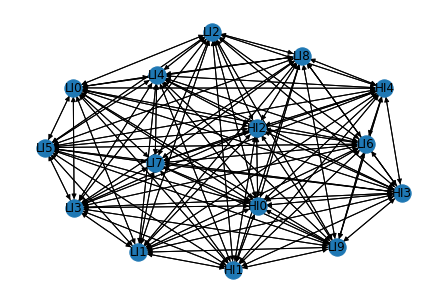

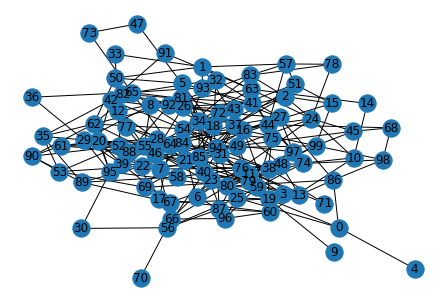

In [68]:
# generate graph
new_honeypot()
new_real_graph()
new_attribute_and_view_graph()

In [69]:
# Hypergame



attacker_collection_list = []
attacker_location = None


# history
attacker_action_history = np.zeros(
    (sub_game_number, att_strategy_number))  # six subgame with 8 strategy
defender_action_history = np.zeros(
    (sub_game_number, def_strategy_number))  # six subgame with 8 strategy
# impact & cost
attack_impact_record = np.ones(att_strategy_number)  # attacker believe all strategy will work initially
defend_impact_record = np.zeros(def_strategy_number)
attack_cost_record = np.zeros(att_strategy_number)
defend_cost_record = np.zeros(def_strategy_number)


# belief
attacker_belief = np.zeros(sub_game_number+1)
defender_belief = np.zeros(sub_game_number+1)

att_CKC_position = 0  # attacker position in CKC
def_guess_CKC_position = 0 # defender guess attacker's stage

# Preset r_ki and c_kj
Prob_att_subgame = np.zeros(sub_game_number)  # six subgame (CKC)
Prob_att_row_per_subgram = np.zeros(
    (sub_game_number, att_strategy_number))  # six subgame with 8 strategy
Prob_att_column_per_subgram = np.zeros((sub_game_number, def_strategy_number))
Prob_def_subgame = np.zeros(sub_game_number)  # six subgame (CKC)
Prob_def_row_per_subgram = np.zeros(
    (sub_game_number, def_strategy_number))  # six subgame with 8 strategy
Prob_def_column_per_subgram = np.zeros((sub_game_number, att_strategy_number))

# mimic Table 4
# add record in advance is to limit strategy in different stage.
# R
attacker_action_history[0, 0] = 1
defender_action_history[0, 0] = 1
defender_action_history[0, 0] = 1
defender_action_history[0, 7] = 1
# D
attacker_action_history[1, 0] = 1
attacker_action_history[1, 1] = 1
defender_action_history[1, 0] = 1
defender_action_history[1, 1] = 1
# E
attacker_action_history[2, 1] = 1
attacker_action_history[2, 2] = 1
attacker_action_history[2, 3] = 1
attacker_action_history[2, 4] = 1
attacker_action_history[2, 6] = 1
defender_action_history[2, 2] = 1
defender_action_history[2, 3] = 1
defender_action_history[2, 4] = 1
defender_action_history[2, 6] = 1
# C2
for i in range(att_strategy_number - 1):
    attacker_action_history[3, i] = 1
for i in range(2, def_strategy_number):
    defender_action_history[3, i] = 1
# M
for i in range(att_strategy_number - 1):
    attacker_action_history[4, i] = 1
for i in range(2, def_strategy_number):
    defender_action_history[4, i] = 1
# DE
for i in range(att_strategy_number):
    attacker_action_history[5, i] = 1
for i in range(2, def_strategy_number):
    defender_action_history[5, i] = 1

update_strategy_probability()

# print("initial row probability")
# print(Prob_att_row_per_subgram)
# print(Prob_def_row_per_subgram)

# update defender subgame with uncertainty 'g'
# defender_uncertainty = defender_uncertainty_update()
# Prob_def_subgame = Prob_def_subgame * (1 - defender_uncertainty)

game_continue = True
while (game_continue):
    system_lifetime += 1

    print("Game: " + str(system_lifetime))

    print("Stage: " + str(att_CKC_position + 1))
    
    # defender guess attacker CKC
    def_CKC_position = def_predict_stage(defender_uncertainty_update()[0], att_CKC_position)
    
    if def_CKC_position == 6:
        def_chosen_strategy = random.randint(0,7)
        print("defender select full game")
    else:
        # defender select strategy
        def_chosen_strategy = defender_choose_strategy(def_CKC_position)
        print("defender strategy: "+str(def_chosen_strategy + 1))

    
    
    # defender behavior
    defender_behavior(def_chosen_strategy)
    
    # attacker select strategy
    att_chosen_strategy = attacker_choose_strategy(att_CKC_position)
    print("attacker strategy: " + str(att_chosen_strategy + 1))

    # attacker behavior
    action_result = attacker_behavior(att_chosen_strategy)
    
    
    # changing stage
    if action_result:
        if att_chosen_strategy == 0 and att_CKC_position == 1:
            print("remain in Stage D")
        elif att_CKC_position >= sub_game_number-1:
            print("stay in stage 6")
        else:
            print("move to next stage")
            att_CKC_position += 1
        # new game, new impact
        attack_impact_record = np.zeros(att_strategy_number)
        defend_impact_record = np.zeros(def_strategy_number)
    

    attacker_action_history[att_CKC_position, att_chosen_strategy] += 1
    update_strategy_probability()
    
    if is_system_fail():
        game_continue = False
        
   

    time.sleep(1)
    print()

In [58]:
# show_all_nodes(G_att)
# draw_graph(G_att)
# draw_graph(G_def)


In [ ]:
a = [14.66666667, -6.66666667, -0,         -0,          0,        -0, 0,         -0        ]
print(a)
all(i <= 0 for i in a)